### Setup

In [1]:
%pip install jax equinox optax optimistix treescope
%load_ext autoreload
%autoreload 2

from functools import partial
import jax
import jax.numpy as jnp
import equinox as eqx
import treescope

Note: you may need to restart the kernel to use updated packages.


### Train model on MNIST

In [2]:
from mnist import mnist_data

_, _, mnist_test_images, mnist_test_labels = mnist_data()

batch_size = 1024
mnist_test_image_batch = mnist_test_images[:batch_size]
mnist_test_label_batch = mnist_test_labels[:batch_size]

# Sort by label
idx = jnp.argsort(mnist_test_label_batch.argmax(-1))
mnist_test_image_batch = mnist_test_image_batch[idx]
mnist_test_label_batch = mnist_test_label_batch[idx]

treescope.render_array(
    mnist_test_image_batch.reshape(-1, 28, 28)[:20],
    pixels_per_cell=1,
    columns=[2, 0],
    axis_labels={0: "input example", 1: "input dimension", 2: "input dimension"},
    vmax=1,
    vmin=-1,
)

<Arrayviz rendering>

In [3]:
%%time
from mnist import train_mnist

mnist_model = train_mnist(num_seeds=10)
mnist_model

Epoch 0		train loss: 2.3 ± 0.00483	test error: 90.02%
Epoch 1		train loss: 0.23 ± 0.0029
Epoch 2		train loss: 0.0891 ± 0.00332
Epoch 3		train loss: 0.161 ± 0.00512
Epoch 4		train loss: 0.044 ± 0.00127
Epoch 5		train loss: 0.0343 ± 0.00185
Epoch 6		train loss: 0.0426 ± 0.00188
Epoch 7		train loss: 0.0302 ± 0.000888
Epoch 8		train loss: 0.0284 ± 0.00132
Epoch 9		train loss: 0.0632 ± 0.00332
Epoch 10		train loss: 0.0147 ± 0.000642
Epoch 11		train loss: 0.0818 ± 0.00513
Epoch 12		train loss: 0.0313 ± 0.00139
Epoch 13		train loss: 0.0156 ± 0.000913
Epoch 14		train loss: 0.0158 ± 0.000546
Epoch 15		train loss: 0.0132 ± 0.000743
Epoch 16		train loss: 0.014 ± 0.000723
Epoch 17		train loss: 0.0153 ± 0.00099
Epoch 18		train loss: 0.0252 ± 0.00362
Epoch 19		train loss: 0.00854 ± 0.000758
Epoch 20		train loss: 0.0277 ± 0.00357
Epoch 21		train loss: 0.0171 ± 0.00105
Epoch 22		train loss: 0.0114 ± 0.000551
Epoch 23		train loss: 0.00851 ± 0.000915
Epoch 24		train loss: 0.00686 ± 0.000635
Epoch 25		tr

MLP(
  layers=(
    Linear(
      weight=f32[10,1024,784],
      bias=None,
      in_features=784,
      out_features=1024,
      use_bias=False
    ),
    Linear(
      weight=f32[10,1024,1024],
      bias=None,
      in_features=1024,
      out_features=1024,
      use_bias=False
    ),
    Linear(
      weight=f32[10,10,1024],
      bias=None,
      in_features=1024,
      out_features=10,
      use_bias=False
    )
  ),
  activation=<wrapped function relu>,
  final_activation=<function <lambda>>,
  use_bias=False,
  use_final_bias=False,
  in_size=784,
  out_size=10,
  width_size=1024,
  depth=2
)

### Manipulate model

In [53]:
from expand import scale_neurons
from expand import duplicate_neurons
from expand import add_random_zero_neurons


@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0), None))
def scale_manipulation(model, scale_factor):
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight
    new_W2, new_W3 = scale_neurons(w_in=W2, w_out=W3, scale_factor=scale_factor)
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0), None))
def duplicate_type_manipulation(model, num_duplicates):
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight
    new_W2, new_W3 = duplicate_neurons(w_in=W2, w_out=W3, num_duplicates=num_duplicates)
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0), None, 0))
def zero_type_manipulation(model, num_units, key):
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight
    new_W2, new_W3 = add_random_zero_neurons(
        w_in=W2, w_out=W3, num_zero_groups=num_units, neurons_per_group=1, key=key
    )
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


@partial(eqx.filter_vmap, in_axes=(None, 0, None))
@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0), None, 0))
def parameter_noise_manipulation(model, noise_scale, key):
    W1 = model.layers[0].weight
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight

    key = jax.random.split(key, 3)
    new_W1 = W1 + noise_scale * jax.random.normal(key[0], W1.shape)
    new_W2 = W2 + noise_scale * jax.random.normal(key[1], W2.shape)
    new_W3 = W3 + noise_scale * jax.random.normal(key[2], W3.shape)

    new_model = eqx.tree_at(lambda x: x.layers[0].weight, model, new_W1)
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, new_model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    print
    return new_model


@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0), None, 0))
def transfer_manipulation(model, transfer_sample_budget, key):
    pass


def accuracy(pred_y, y):
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(pred_y, axis=1)
    return jnp.mean(predicted_class == target_class)


@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0),))
def gen_error(model):
    pred_y = eqx.filter_vmap(model)(mnist_test_images)
    test_error = 1 - accuracy(pred_y, mnist_test_labels)
    return test_error

In [23]:
gen_error(mnist_model)

Array([0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
       0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],      dtype=float32)

In [24]:
gen_error(scale_manipulation(mnist_model, 10))

Array([0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
       0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],      dtype=float32)

In [28]:
gen_error(duplicate_type_manipulation(mnist_model, 10))

Array([0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
       0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],      dtype=float32)

In [27]:
key = jax.random.PRNGKey(37)
zero_type_manipulation(mnist_model, 10, jax.random.split(key, 10))

MLP(
  layers=(
    Linear(
      weight=f32[10,1024,784],
      bias=None,
      in_features=784,
      out_features=1024,
      use_bias=False
    ),
    Linear(
      weight=f32[10,1034,1024],
      bias=None,
      in_features=1024,
      out_features=1024,
      use_bias=False
    ),
    Linear(
      weight=f32[10,10,1044],
      bias=None,
      in_features=1024,
      out_features=10,
      use_bias=False
    )
  ),
  activation=<wrapped function relu>,
  final_activation=<function <lambda>>,
  use_bias=False,
  use_final_bias=False,
  in_size=784,
  out_size=10,
  width_size=1024,
  depth=2
)

In [29]:
gen_error(zero_type_manipulation(mnist_model, 10, jax.random.split(key, 10)))

TypeError: dot_general requires contracting dimensions to have the same shape, got (1044,) and (1034,).

In [57]:
key = jax.random.PRNGKey(37)
noise_scales = jnp.array(tuple(10**-i for i in range(9, -1, -1)))
data = eqx.filter_vmap(gen_error, in_axes=(eqx.if_array(0),))(
    parameter_noise_manipulation(mnist_model, noise_scales, jax.random.split(key, 10))
)
data

Array([[0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
        0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],
       [0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
        0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],
       [0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
        0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],
       [0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
        0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],
       [0.01960003, 0.01930004, 0.01920003, 0.01950002, 0.0194    ,
        0.01800001, 0.01920003, 0.01900005, 0.01930004, 0.01890004],
       [0.01960003, 0.01930004, 0.01910001, 0.01960003, 0.01930004,
        0.01800001, 0.01910001, 0.01890004, 0.01920003, 0.01890004],
       [0.01970005, 0.01930004, 0.01920003, 0.01980001, 0.01930004,
        0.01800001, 0.01890004, 0.0187    , 0.01860005, 0.01910001],
       [0.02000004, 0.02110004, 0.0202000

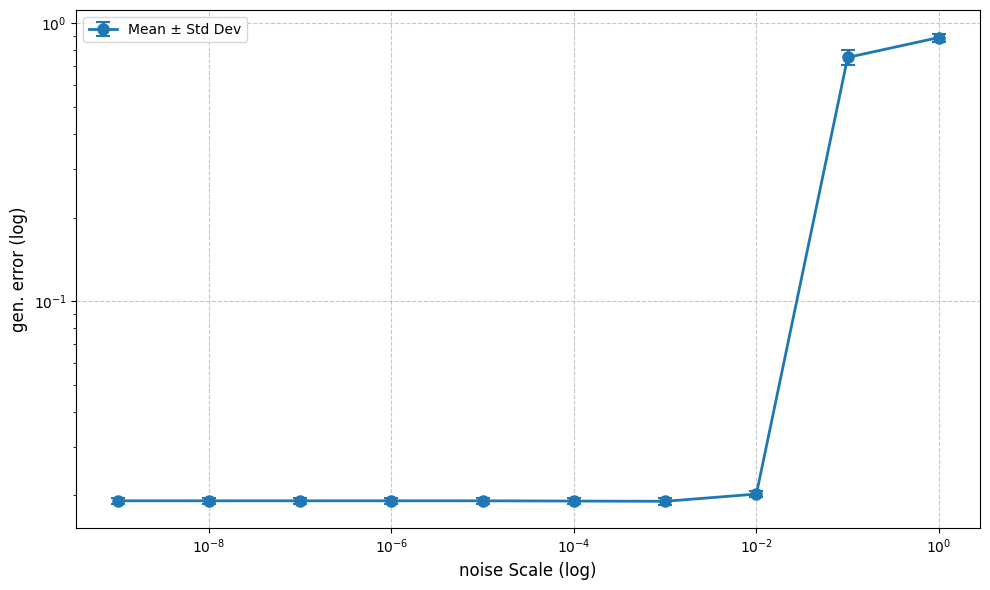

In [62]:
import numpy as np
import matplotlib.pyplot as plt

means = np.mean(data, axis=1)
stds = np.std(data, axis=1)

means = np.mean(data, axis=1)
stds = np.std(data, axis=1)

plt.figure(figsize=(10, 6))
plt.errorbar(
    noise_scales,
    means,
    yerr=stds,
    fmt="o-",
    capsize=5,
    capthick=1.5,
    linewidth=2,
    markersize=8,
    label="Mean ± Std Dev",
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("noise scale (log)", fontsize=12)
plt.ylabel("gen. error (log)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()